In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike
from scipy import signal
from scipy import interpolate
import os
import pytz
import time
import re

variables

In [2]:
outD = 7.77010            # primary diameter (m)
inD = 1.024               # inner M2 diameter (m)
n = 48                    # number sample points across the screen (Not the number of subapertures)
nacross = 43              # number of subapertures across the aperture
pscale = outD/(nacross)   # pixel size (m) of samples in pupil plane

Make the aperture

In [3]:
#  Aperture containing zeros
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= (7.3)/2) #slightly oversized because GPI does not correct teh boundaries well
ap_inner = (ar <= 1.5/2)   

#ap_outer = (ar <= outD/2)
#ap_inner = (ar <= inD/2)   
ap = (ap_outer ^ ap_inner).astype(np.float)

#  Aperture containing nans
ap_nan = np.copy(ap.astype(np.float))  
ap_nan[np.where(ap==0)] = np.nan

/home/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Make the freq grid

In [4]:
kx = fft.fftshift(fft.fftfreq(n,pscale))
ky = fft.fftshift(fft.fftfreq(n,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

/home/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.


Navigating Files and Paths

In [5]:
rootdir = '/home/sda/mtallis/PhaseScripts/aotelem/Reduced/'
save_path = '/home/sda/mtallis/Results/AU_Mic/'
dstr = time.strftime('%Y%m%d')

In [46]:
with open('/home/sda/mtallis/GPIDomeSeeing/samples/AU_Mic_samples_20190206.txt','r') as f:
    sample = f.read().splitlines()

In [64]:
fname_list = list()
name_list = list()

for i in sample:
    for root, dirs, files in os.walk(rootdir):
        for name in files:
            (base,ext) = os.path.splitext(name)
            if (ext in ('.fits')) and (i in base):
                full_name = os.path.join(root,name)
                print(full_name)
                fname_list.append(full_name)  
                name_list.append(base[11:-12])

/home/sda/mtallis/PhaseScripts/aotelem/Reduced/20141110/aored_When_2014.11.10_0.39.7_poldm_phase.fits
/home/sda/mtallis/PhaseScripts/aotelem/Reduced/20141110/aored_When_2014.11.10_0.40.2_poldm_phase.fits
/home/sda/mtallis/PhaseScripts/aotelem/Reduced/20141110/aored_When_2014.11.10_0.41.2_poldm_phase.fits
/home/sda/mtallis/PhaseScripts/aotelem/Reduced/20150703/aored_When_2015.7.3_7.27.19_poldm_phase.fits
/home/sda/mtallis/PhaseScripts/aotelem/Reduced/20150703/aored_When_2015.7.3_7.28.32_poldm_phase.fits
/home/sda/mtallis/PhaseScripts/aotelem/Reduced/20150703/aored_When_2015.7.3_7.30.45_poldm_phase.fits


Routines

In [50]:
def process_phase(filepath):

    hdulist = fits.open(filepath,memmap=True)
    phase = hdulist[0].data.astype('float')
    avg_phase = np.nanmean(phase*ap_nan,axis=0)  # used to find average zernikes 

    # remove zernikes form cube
    z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
    z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=ap, nterms=6)
    thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

    c_phase = (phase - thin_lens[None,:,:])*ap_nan
    c_phase[np.isnan(c_phase)]=0.
    
    return c_phase

In [54]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    mean = sy/n
    
    return mean

In [55]:
k = radialProfile(kr)

In [56]:
def sp_power_spec(phase):    
    
    timesteps, phx, phy = phase.shape 
    phFT = np.zeros((timesteps,phx,phy), dtype=complex)
    for t in np.arange(timesteps):
        phFT[t,:,:] = fft.fftshift(fft.fft2(phase[t,:,:]))*2.0/ap.sum()
    print('Done with FT')
    
    # compute 2d psd cube
    psd2D = np.zeros((timesteps, phx, phy),dtype=float)
    for k in np.arange(phx):
        for l in np.arange(phy):
            psd2D[:,k,l] = np.square(np.abs(phFT[:,k,l]))
    
    avg_psd2D = np.mean(psd2D, axis=0)
    print('Done with PSD')    
    
    # compute radial average of 2d psd cube and frequency
    avg_psd1D =  radialProfile(avg_psd2D)
    
    return avg_psd1D

In [57]:
def linear_fit(k,Y):
    
    par = np.polyfit(np.log10(k[(k>1/7.25) & (k<1/.36)]), np.log10(Y[(k>1/7.25) & (k<1/.36)]), 1)
    slope = par[0]
    intercept = par[1]
    
    print(slope,intercept)

    return slope,intercept

<IPython.core.display.Javascript object>


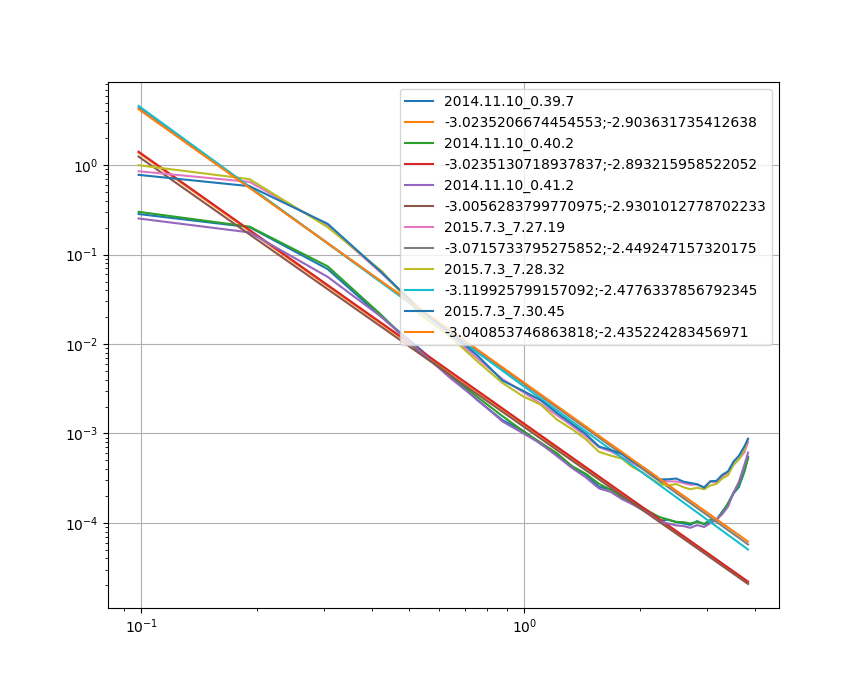

/home/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: Mean of empty slice
/home/anaconda3/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Done with FT
Done with PSD
-3.0235206674454553 -2.903631735412638
Done with FT
Done with PSD
-3.0235130718937837 -2.893215958522052
Done with FT
Done with PSD
-3.0056283799770975 -2.9301012778702233
Done with FT
Done with PSD
-3.0715733795275852 -2.449247157320175
Done with FT
Done with PSD
-3.119925799157092 -2.4776337856792345
Done with FT
Done with PSD
-3.040853746863818 -2.435224283456971


In [67]:
%matplotlib notebook

plt.figure(1)
i=0
for file in fname_list:
    y_2D = process_phase(file)
    y_psd = sp_power_spec(y_2D)
    m, intercept = linear_fit(k,y_psd)
    plt.loglog(k,y_psd, label = name_list[i])
    plt.loglog(k, (10**intercept)*k**m,label=str(m)+';'+str(intercept))
    i=i+1

plt.grid(axis='both')
plt.legend()